In [90]:
import numpy as np
import random
from IPython.display import Image, display 
from graphviz import Digraph

# Define constants, variables, and operators
constant_range = np.linspace(0.5, 10, num=40)
CONSTANTS = list(constant_range)

def safe_divide(a, b):
    return np.divide(a, b, where=b != 0, out=np.full_like(a, np.nan)) # Safe divide for b != 0, else nan. With NaN, you'll know exactly where and why a result is invalid. With 0, you'll have valid numbers for calculations, but the invalid results may not be easy to track.

def safe_sqrt(a):
    return np.sqrt(a, where=a >= 0, out=np.full_like(a, np.nan)) # Safe sqrt for non-negative a, else nan. 

def safe_log(a):
    return np.log(a, where=a > 0, out=np.full_like(a, -np.inf)) # Safe log for positive a, else -inf

# def safe_log10(a):
#     return np.log10(a, where=a > 0, out=np.full_like(a, -np.inf)) # Safe log10 for positive a, else -inf

# OPERATORS = {
#     'add': np.add,
#     'sub': np.subtract,
#     'mul': np.multiply,
#     'div': safe_divide,
#     'sin': np.sin,
#     'cos': np.cos,
#     'tan': np.tan,
#     'sqrt': safe_sqrt,
#     'log': safe_log,
#     'log10': safe_log10,
#     'pow': np.power,
#     'abs': np.abs,
#     'sinh': np.sinh,
#     'cosh': np.cosh,
#     'tanh': np.tanh,
#     'exp': np.exp,
#     'square': np.square,
# }

OPERATORS = {
    'add': np.add,
    'sub': np.subtract,
    'mul': np.multiply,
    'div': safe_divide,
    'sin': np.sin,
    'cos': np.cos,
    'tan': np.tan,
    'sqrt': safe_sqrt,
    'log': safe_log,
}

Node class

In [91]:
class Node:
    def __init__(self, value, is_operator=False):
        """
        Initialize a Node.
        
        :param value: The value of the node (operator, constant, or variable name).
        :param is_operator: True if the node represents an operator, otherwise False.
        """
        self.value = value
        self.is_operator = is_operator
        self.left = None
        self.right = None

    def evaluate(self, variables):
        """
        Evaluate the subtree rooted at this node.
        
        :param variables: A dictionary mapping variable names to their values.
        :return: The result of evaluating the subtree.
        """
        # Check for None values to avoid errors
        if self is None:
            return 0

        if self.is_operator:
            # Unary operator (e.g., sin, log, etc.)
            #if self.value in ['sin', 'cos', 'tan', 'sqrt', 'log', 'log10', 'sinh', 'cosh', 'tanh', 'exp', 'square', 'abs']:
            if self.value in ['sin', 'cos', 'tan', 'sqrt', 'log']:    
                if self.left is None:
                    raise ValueError(f"Missing left child for operator {self.value}")
                left_value = self.left.evaluate(variables)
                return OPERATORS[self.value](left_value)
            
            # Binary operator (e.g., add, sub, mul, div, etc.)
            #elif self.value in ['add', 'sub', 'mul', 'div', 'pow']:
            elif self.value in ['add', 'sub', 'mul', 'div']:
                if self.left is None or self.right is None:
                    raise ValueError(f"Missing children for operator {self.value}")
                left_value = self.left.evaluate(variables)
                right_value = self.right.evaluate(variables)
                return OPERATORS[self.value](left_value, right_value)
        
        elif self.value in variables:
            # Variable node (e.g., x0, x1, etc.)
            return variables[self.value]
        
        # Constant node (just return the constant value)
        return self.value

Individual class

In [92]:
class Individual:
    def __init__(self, root, file_path):
        """
        Initialize an Individual (a tree).
        
        :param root: The root node of the tree.
        """
        self.root = root
        self.fitness_value = None
        
        if file_path:
            self.fitness_value = self.fitness(file_path)

    def evaluate(self, variables):
        """
        Evaluate the tree.
        
        :param variables: A dictionary mapping variable names to their values.
        :return: The result of evaluating the tree.
        """
        return self.root.evaluate(variables)
    
    def tree_size(self):
        """
        Return the number of nodes in the tree.
        """
        def count_nodes(node):
            if node is None:
                return 0
            return 1 + count_nodes(node.left) + count_nodes(node.right)
        
        return count_nodes(self.root)

    def fitness(self, file_path):
        """
        Calculate the fitness of the individual using Mean Squared Error (MSE).
        
        :param file_path: Path to the .npz file containing 'x' and 'y'.
        :return: The MSE between the predicted and actual y values.
        """
        # Load the data
        data = np.load(file_path)
        x = data['x']
        y = data['y']

        # Initialize variables for prediction
        num_features = x.shape[0]
        variables = {f'x{i}': None for i in range(num_features)}

        # Compute predictions
        y_pred = []
        for i in range(x.shape[1]):  # Iterate over each column
            for j in range(num_features):  # Set variable values for this row
                variables[f'x{j}'] = x[j, i]
            y_pred.append(self.evaluate(variables))
        y_pred = np.array(y_pred)

        # Calculate MSE
        mse = np.mean((y - y_pred) ** 2)
        return mse
    
    #variant of fitness involving complexity penalty
    def fitness2(self, file_path, complexity_penalty=0.01):
        data = np.load(file_path)
        x = data['x']
        y = data['y']
        num_features = x.shape[0]
        variables = {f'x{i}': None for i in range(num_features)}

        y_pred = []
        for i in range(x.shape[1]):
            for j in range(num_features):
                variables[f'x{j}'] = x[j, i]
            y_pred.append(self.evaluate(variables))
        y_pred = np.array(y_pred)

        mse = np.mean((y - y_pred) ** 2)
        return mse + complexity_penalty * self.tree_size()

    def get_all_nodes(self):
        """
        Retrieve all nodes in the tree.

        :return: A list of all nodes in the tree.
        """
        def collect_nodes(node):
            if node is None:
                return []
            return [node] + collect_nodes(node.left) + collect_nodes(node.right)

        return collect_nodes(self.root)
    

    def __str__(self):
        """
        Return a string representation of the tree.
        """
        return self._str_helper(self.root)

    def _str_helper(self, node):
        """
        Helper function for string representation. Recursively traverse the tree.
        """
        if node is None:
            return ""
        
        if node.is_operator:
            if node.right is not None:
                return f"({node.value}({self._str_helper(node.left)}, {self._str_helper(node.right)})"
            else:
                return f"{node.value}({self._str_helper(node.left)})"
        return str(node.value)

In [93]:
def mse_percentage(mse_value, file_path):
        """
        Calculate the MSE percentage to assess how logical the fitness value is.

        :param file_path: Path to the .npz file containing 'x' and 'y'.
        :return: The MSE percentage.
        """
        
        # Load the data to get the y values for min and max
        data = np.load(file_path)
        y = data['y']
        
        # Calculate the range of y values
        y_max = np.max(y)
        print(y_max)
        y_min = np.min(y)
        print(y_min)
        
        # Calculate the MSE percentage
        mse_percentage = (mse_value / (y_max - y_min)) * 100
        
        return mse_percentage

Create tree

In [94]:
# Create a random tree out of the class Individual
def create_tree(num_nodes, file_name):
    """
    Create a random tree with the specified number of nodes.
    
    :param num_nodes: The number of nodes in the tree.
    :param file_name:  .npz file.
    :return: A random tree as an Individual object.
    """
    # Assuming x_data is loaded from 'problem_20.npz', let's load it properly
    data = np.load(file_name)
    x_data = data['x']  # Assuming 'x' is the key for your data in the .npz file
    y_data = data['y']  # Assuming 'y' is the key for your labels (if you need it)

    # Make sure x_data is a NumPy array
    x_data = np.array(x_data)

    num_vars = x_data.shape[0]  # Number of variables (rows in x)
    VARIABLES = [f'x{i}' for i in range(num_vars)]  # Generate the variable names dynamically
    variable_included = False  # Flag to check if at least one variable is included in the tree

    def random_node(is_operator=False):
        """Helper function to generate a random node (operator or constant/variable)."""
        nonlocal variable_included
        if is_operator:
            # Random operator node (should never be a terminal node)
            value = random.choice(list(OPERATORS.keys()))
            return Node(value, is_operator=True)
        else:
            # Random constant or variable node (only for leaf nodes)
            value = random.choice(CONSTANTS) if random.random() < 0.1 else random.choice(VARIABLES)
            if value in VARIABLES:
                variable_included = True
            return Node(value, is_operator=False)

    def build_tree(nodes_left, is_root=True):
        """Recursively build a tree. Ensure the first node is not a terminal node."""
        if nodes_left == 1:
            # If only one node is left, it should be a terminal node (constant or variable)
            return random_node(is_operator=False), 1
        else:
            # Choose an operator (either unary or binary)
            operator = random.choice(list(OPERATORS.keys()))
            node = Node(operator, is_operator=True)

            if operator in ['sin', 'cos', 'tan', 'sqrt', 'log']:
            #if operator in ['sin', 'cos', 'tan', 'sqrt', 'log', 'log10', 'sinh', 'cosh', 'tanh', 'exp', 'square', 'abs']:
                # Unary operator: Only one child is required
                right_subtree_size = nodes_left - 1
                right_child, _ = build_tree(right_subtree_size, is_root=False)
                node.left = right_child
                return node, 1 + right_subtree_size  # 1 for the operator, + subtree size
            elif operator in ['add', 'sub', 'mul', 'div']:
            #elif operator in ['add', 'sub', 'mul', 'div', 'pow']:
                # Binary operator: Two children are required
                if nodes_left <= 2:
                    # If there are only two nodes left, force it to be a terminal node
                    left_subtree_size = 1
                    right_subtree_size = 1
                else:
                    right_subtree_size = random.randint(1, nodes_left - 2)
                    left_subtree_size = nodes_left - 1 - right_subtree_size

                # Build left and right subtrees
                left_child, left_size = build_tree(left_subtree_size, is_root=False)
                right_child, right_size = build_tree(right_subtree_size, is_root=False)

                node.left = left_child
                node.right = right_child

                return node, 1 + left_size + right_size  # 1 for the operator, + left and right subtree sizes

    # Build the tree and return it as an Individual object
    root_node, _ = build_tree(num_nodes)
    
    # Ensure at least one variable is included
    if not variable_included:
        print("No variable included in the tree; retrying...")
        return create_tree(num_nodes, file_name)  # Retry tree creation if no variable was included
    
    return Individual(root_node, file_name)
#expanding it on the right side first and putting the terminal nodes on the left side

#variant of create_tree with depth constraints
def create_tree2(num_nodes, file_name, max_depth=5):
    """
    Create a random tree with depth constraints.

    :param num_nodes: The number of nodes in the tree.
    :param x_data: Input variable data.
    :param max_depth: Maximum allowable tree depth.
    :return: A random tree as an Individual object.
    """
    # Assuming x_data is loaded from 'problem_20.npz', let's load it properly
    data = np.load(file_name)
    x_data = data['x']  # Assuming 'x' is the key for your data in the .npz file
    y_data = data['y']  # Assuming 'y' is the key for your labels (if you need it)

    # Make sure x_data is a NumPy array
    x_data = np.array(x_data)

    
    num_vars = x_data.shape[0]
    VARIABLES = [f'x{i}' for i in range(num_vars)]

    def build_tree(depth=0):
        # Stop building if the maximum depth is reached or no nodes remain
        if depth >= max_depth or num_nodes <= 1:
            value = random.choice(CONSTANTS + VARIABLES)
            return Node(value, is_operator=False)

        # Choose operator or terminal node based on probability
        is_operator = random.random() < 0.7
        if not is_operator:
            value = random.choice(CONSTANTS + VARIABLES)
            return Node(value, is_operator=False)

        # Create operator node
        operator = random.choice(list(OPERATORS.keys()))
        node = Node(operator, is_operator=True)

        # Build subtrees for binary or unary operators
        if operator in ['add', 'sub', 'mul', 'div', 'pow']:
            node.left = build_tree(depth + 1)
            node.right = build_tree(depth + 1)
        elif operator in ['sin', 'cos', 'tan', 'sqrt', 'log']:
            node.left = build_tree(depth + 1)
        return node

    return Individual(build_tree())

In [95]:
individual = create_tree(7, '../data/problem_7.npz')
print(individual)

(div(x0, (mul((mul(x1, x1), tan(x0)))


In [96]:
# Install graphviz package
%pip install graphviz

from graphviz import Digraph
def visualize_tree(node, graph=None, parent_name=None, unique_id=0):
    """
    Recursively visualize the tree using Graphviz.
    
    :param node: The current node to visualize.
    :param graph: The Graphviz Digraph object (created once and passed recursively).
    :param parent_name: The name of the parent node (used for connecting edges).
    :param unique_id: Unique identifier for nodes (to ensure uniqueness in Graphviz).
    :return: Updated Graphviz Digraph object.
    """
    if graph is None:
        graph = Digraph(format="png")  # Create a directed graph
    
    # Unique name for the current node
    node_name = f"Node{unique_id}"
    label = str(node.value)
    graph.node(node_name, label=label)  # Add the current node
    
    # If there's a parent, add an edge from the parent to the current node
    if parent_name is not None:
        graph.edge(parent_name, node_name)
    
    # Recursively visualize left and right children
    child_id = unique_id + 1
    if node.left:
        graph = visualize_tree(node.left, graph, node_name, child_id)
        child_id += 1
    if node.right:
        graph = visualize_tree(node.right, graph, node_name, child_id)
    
    return graph

Note: you may need to restart the kernel to use updated packages.


In [97]:
def draw_tree(tree):
    dot = Digraph(comment='Tree')
    
    # Set to track unique nodes by their value, but we're not excluding repeats
    node_counter = {}  # This will help track how many times a node has been used
    
    def add_edges(node, parent=None):
        if node:
            # Create a unique identifier for the node based on its value and repetition count
            node_name = str(node.value)
            
            # Track how many times we've seen this node (for repeating nodes)
            if node_name not in node_counter:
                node_counter[node_name] = 0
            node_counter[node_name] += 1

            # Append the repetition count to make the node name unique
            unique_node_name = f"{node_name}_{node_counter[node_name]}"

            # Add node to the graph if it has not been added
            dot.node(unique_node_name, label=str(node.value))
            
            if parent:
                # Connect parent to this node
                dot.edge(str(parent), unique_node_name)

            # Recursively add left and right children
            if node.left:
                add_edges(node.left, unique_node_name)
            if node.right:
                add_edges(node.right, unique_node_name)

    # Start from the root of the tree
    add_edges(tree.root)

    # Render the graph to a file and view it
    #dot.render('tree_visualization')
    
    img_data = dot.pipe(format='png')
    display(Image(img_data))


Random Tree Structure: cos(sqrt((div(sin(x0), (mul(cos(sin(x1)), x3))))
Fitness (MSE) for random tree: nan
Fitness2 (MSE) for random tree: nan


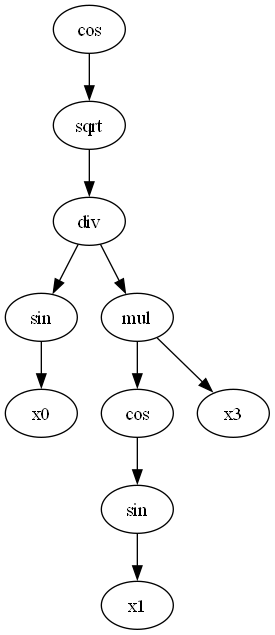

In [99]:
# Create a random example 'problem_20.npz' for testing
x = np.random.rand(5, 100) * 10  # Random x values with shape (5, 100)
y = np.sin(x[0]) + x[1] * 2 - np.sqrt(x[2] + x[3]) + x[4] * 3  # Example expression for y

# Save to problem_20.npz
np.savez('problem_20.npz', x=x, y=y)

# Generate a random tree with 10 nodes, dynamically generating variables for x
random_tree = create_tree(10, 'problem_20.npz')
#random_tree = create_tree2(10, x, 5)


# Print the structure of the random tree
print("Random Tree Structure:", random_tree)
graph = visualize_tree(random_tree.root)
graph.render('random_tree')  # Save the tree visualization to a file

# Calculate the fitness of the random tree (using the saved file 'problem_20.npz')
fitness_value = random_tree.fitness('problem_20.npz')
fitness_value2 = random_tree.fitness2('problem_20.npz', 0.1)
print("Fitness (MSE) for random tree:", fitness_value)
print("Fitness2 (MSE) for random tree:", fitness_value2)

draw_tree(random_tree)

x dtype: float64, x shape: (2, 1000)
Random Tree Structure: (mul(sin(cos(x1)), cos(sqrt(sin((div(x0, x0)))))
Fitness (MSE) for random tree: 515.1416898711803
Fitness2 (MSE) for random tree: 516.1416898711803


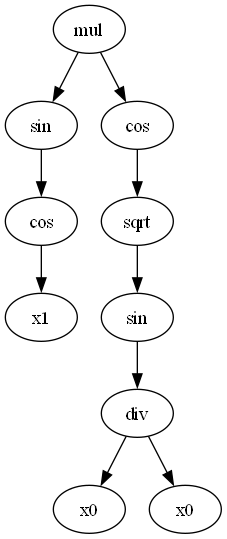

In [101]:
data = np.load('../data/problem_0.npz')
x = data['x']
y = data['y']

print(f"x dtype: {x.dtype}, x shape: {x.shape}")

random_tree = create_tree(10, '../data/problem_0.npz')
#random_tree = create_tree2(10, x, 5)


# Print the structure of the random tree
print("Random Tree Structure:", random_tree)
graph = visualize_tree(random_tree.root)
graph.render('random_tree')  # Save the tree visualization to a file

# Calculate the fitness of the random tree (using the saved file 'problem_20.npz')
fitness_value = random_tree.fitness('problem_20.npz')
fitness_value2 = random_tree.fitness2('problem_20.npz', 0.1)
print("Fitness (MSE) for random tree:", fitness_value)
print("Fitness2 (MSE) for random tree:", fitness_value2)

draw_tree(random_tree)

Population class

In [102]:
class Population:
    def __init__(self, size, num_nodes, file_name):
        """
        Initialize a population of random individuals (trees).
        
        :param size: Number of individuals in the population.
        :param num_nodes: Number of nodes for each tree.
        :param x_data: The x data to determine the number of variables.
        :param max_depth: Optional maximum depth for each tree.
        """
        # self.individuals = [
        #     create_tree(num_nodes, x_data) for _ in range(size)
        # ]
        
        # Assuming x_data is loaded from 'problem_20.npz', let's load it properly
        data = np.load(file_name)
        x_data = data['x']  # Assuming 'x' is the key for your data in the .npz file
        y_data = data['y']  # Assuming 'y' is the key for your labels (if you need it)

        # Make sure x_data is a NumPy array
        x_data = np.array(x_data)
        
        self.size = size
        self.individuals = []
        while len(self.individuals) < size:
            individual = create_tree(num_nodes, file_name)
            fitness_value = individual.fitness2(file_name, complexity_penalty=0.01)
            if np.isnan(fitness_value) or np.isinf(fitness_value):
                continue
            if individual.tree_size() == num_nodes:
                self.individuals.append(individual) 

    def evaluate_fitness(self, file_path, complexity_penalty=0.01):
        """
        Evaluate the fitness of all individuals in the population.
        
        :param file_path: Path to the .npz file containing 'x' and 'y'.
        :param complexity_penalty: Penalty for tree complexity.
        """
        for individual in self.individuals:
            individual.fitness_value = individual.fitness2(file_path, complexity_penalty)
        
    def get_best_individual(self):
        """
        Get the individual with the best fitness in the population.
        
        :return: The best individual.
        """
        return min(self.individuals, key=lambda ind: ind.fitness_value)
    
    def get_worst_individual(self):
        """
        Get the individual with the best fitness in the population.
        
        :return: The best individual.
        """
        return max(self.individuals, key=lambda ind: ind.fitness_value)

    def get_average_fitness(self):
        """
        Get the average fitness of the population.
        
        :return: Average fitness value.
        """
        return np.mean([ind.fitness_value for ind in self.individuals])
    
    def tournament_selection(self, tournament_size=10):
        """
        Perform probabilistic tournament selection to choose an individual from the population.
        
        :param tournament_size: Number of individuals in the tournament.
        :return: The selected individual.
        """
        # Randomly select individuals for the tournament
        tournament = random.sample(self.individuals, tournament_size)
        
        # Individual with best fitness
        winner = min(tournament, key=lambda ind: ind.fitness_value)

        return winner

In [109]:
def get_random_node(tree):
    """
    Select a random node from the tree.
    
    :return: A randomly selected node from the tree.
    """
    all_nodes = tree.get_all_nodes()
    return random.choice(all_nodes) if all_nodes else None

def get_node_with_temperature(tree, temperature=1.0):
        """
        Select a node from the tree where the likelihood of selection depends on the subtree size
        if temperature > 0.8 then it will select a random node from the tree
        else it will select a random node with subtrees of size less than or equal to half of the tree size
        
        :param temperature: A value between 0 and 1. Higher values favor exploration (larger subtrees),
                            lower values favor exploitation (smaller subtrees).
        :return: A randomly selected node.
        """        
        nodes = tree.get_all_nodes()
        subtree_sizes = [Individual(node).tree_size() for node in nodes]

        if temperature > 0.8:
            return random.choice(nodes)
        else:
            small_subtrees = [node for node, size in zip(nodes, subtree_sizes) if size <= tree.root.tree_size() / 2]
            return random.choice(small_subtrees) if small_subtrees else random.choice(nodes)


def get_node_with_temperature(tree, temperature=1.0):
        """
        Select a node from the tree where the likelihood of selection depends on the subtree size
        and the given temperature parameter (between 0 and 1).
        
        :param temperature: A value between 0 and 1. Higher values favor exploration (larger subtrees),
                            lower values favor exploitation (smaller subtrees).
        :return: A randomly selected node.
        """        
        nodes = tree.get_all_nodes()
        subtree_sizes = [Individual(node).tree_size() for node in nodes]

        # Adjust weights based on temperature
        # Map temperature (0 to 1) such that 0 biases toward smaller subtrees and 1 biases toward larger subtrees
        # Subtree size weight: (1 - temperature) biases toward small, temperature biases toward large
        max_size = max(subtree_sizes)
        weights = [(temperature * size / max_size) + ((1 - temperature) * (1 / size)) for size in subtree_sizes]

        # Normalize weights to calculate probabilities
        total_weight = sum(weights)
        probabilities = [weight / total_weight for weight in weights]

        # Randomly select a node based on the calculated probabilities
        selected_node = random.choices(nodes, weights=probabilities, k=1)[0]
        return selected_node


def rebuild_subtree(tree, node):
    """
    Rebuild a subtree starting from the given node, replicating it exactly.
    
    :param node: The root node of the subtree to replicate.
    :return: A new Node that is a copy of the subtree rooted at `node`.
    """
    if node is None:
        return None

    # Create a copy of the current node
    new_node = Node(value=node.value, is_operator=node.is_operator)

    # Recursively copy the left and right children
    new_node.left = rebuild_subtree(tree, node.left)
    new_node.right = rebuild_subtree(tree, node.right)

    return new_node


def extract_and_rebuild_subtree(tree, temperature=1.0):
    """
    Extract and rebuild a random subtree from the tree.
    
    :param temperature: Temperature parameter to control randomness (not yet used).
    :return: A new subtree that is a copy of the randomly chosen subtree.
    """
    # Get a random node from the tree
    #random_node = get_random_node(tree)
    random_node = get_node_with_temperature(tree, temperature)
    if random_node is None:
        raise ValueError("Tree is empty; cannot extract a subtree.")

    # Rebuild the subtree starting from the selected node
    subtree = Individual(rebuild_subtree(tree, random_node))
    return subtree


def replace_subtree(tree, target_node, new_subtree):
    """
    Replace a subtree in the tree with a new subtree.
    
    :param tree: The tree (Individual) to modify.
    :param target_node: The node where the replacement should happen.
    :param new_subtree: The new subtree to replace the old one.
    :return: The modified tree (Individual).
    """
    # Find the parent node of the target node
    parent_node = None
    stack = [tree.root]
    while stack:
        current_node = stack.pop()
        if current_node.left == target_node or current_node.right == target_node:
            parent_node = current_node
            break
        if current_node.left:
            stack.append(current_node.left)
        if current_node.right:
            stack.append(current_node.right)

    # Replace the target node with the new subtree
    if parent_node:
        if parent_node.left == target_node:
            parent_node.left = new_subtree
        else:
            parent_node.right = new_subtree
    else:
        # If the target node is the root, replace the entire tree
        tree.root = new_subtree

    return tree


def subtree_mutation(tree, file_name, temperature=1.0):
    """
    Perform subtree mutation on a given tree.
    
    :param tree: The tree (root node) to mutate.
    :param x_data: The x_data to use for generating new subtrees.
    :param temperature: A parameter controlling randomness (not yet used).
    """
    # Get a random node from the tree
    target_node = get_random_node(tree)
    
    if target_node is None:
        raise ValueError("Tree is empty; cannot perform mutation.")

    # Calculate the size of the subtree rooted at the selected node
    subtree_individual = Individual(target_node, file_name)
    subtree_size = subtree_individual.tree_size()

    # Create a new subtree with the same size
    new_subtree = create_tree(subtree_size, file_name).root

    # Replace the selected subtree with the new one
    replace_subtree(tree, target_node, new_subtree)
    
    return tree

def subtree_crossover(tree1, tree2, temperature=1.0):
    """
    Perform subtree crossover between two trees.
    
    :param tree1: The first tree (Individual) to crossover.
    :param tree2: The second tree (Individual) to crossover.
    :param x_data: The x_data to use for generating new subtrees.
    :param temperature: A parameter controlling randomness (not yet used).
    :return: Two new trees resulting from the crossover operation.
    """
    node1, node2 = tree1, tree2
    # Get random nodes from each tree
    # while Individual(node1).tree_size() > Individual(tree1).tree_size() / 2:
    #     node1 = get_random_node(tree1)
    # while Individual(node2).tree_size() > Individual(tree1).tree_size() / 2:
    #     node2 = get_random_node(tree2)
        
    node1 = get_random_node(tree1)
    node2 = get_random_node(tree2)
    
    if node1 is None or node2 is None:
        raise ValueError("One or both trees are empty; cannot perform crossover.")
    
    # Extract subtrees from each tree
    subtree1 = rebuild_subtree(tree1, node1)
    subtree2 = rebuild_subtree(tree2, node2)
    
    # Replace subtrees in the opposite trees
    new_tree1 = replace_subtree(tree1, node1, subtree2)
    new_tree2 = replace_subtree(tree2, node2, subtree1)
    
    return new_tree1, new_tree2

In [111]:
#Assuming x_data is loaded from 'problem_20.npz', let's load it properly
data = np.load('../data/problem_0.npz')
x_data = data['x']  # Assuming 'x' is the key for your data in the .npz file
y_data = data['y']  # Assuming 'y' is the key for your labels (if you need it)

# Make sure x_data is a NumPy array
x_data = np.array(x_data)

# Create a random tree
random_tree = create_tree(10, '../data/problem_0.npz')
#draw_tree(random_tree)

print("Random Tree Structure:", random_tree)

# subtree = extract_and_rebuild_subtree(random_tree, temperature =1.0)
# draw_tree(subtree)

# new_subtree = create_tree(subtree.tree_size(), x_data)
# draw_tree(new_subtree)

#Perform subtree mutation
mutated = subtree_mutation(random_tree, file_name='../data/problem_0.npz')
#draw_tree(mutated)
print("Mutated Tree Structure:", mutated)

Random Tree Structure: sqrt((sub(3.423076923076923, (add(6.346153846153846, tan((div(x0, (sub(x0, x1))))))
Mutated Tree Structure: sqrt((sub(3.423076923076923, (add(6.346153846153846, (sub((mul(x1, sqrt(x0)), x1))))


In [114]:
#Assuming x_data is loaded from 'problem_20.npz', let's load it properly
data = np.load('../data/problem_0.npz')

file_name = '../data/problem_0.npz'
x_data = data['x']  # Assuming 'x' is the key for your data in the .npz file
y_data = data['y']  # Assuming 'y' is the key for your labels (if you need it)

# Make sure x_data is a NumPy array
x_data = np.array(x_data)

# Create a random tree
random_tree1 = create_tree(10, file_name)
#draw_tree(random_tree1)
print(random_tree1)
random_tree2 = create_tree(10, file_name)
#draw_tree(random_tree2)
print(random_tree2)

new_tree1, new_tree2 = subtree_crossover(random_tree1, random_tree2)
#draw_tree(new_tree1)
#draw_tree(new_tree2)
print(new_tree1)
print(new_tree2)

sqrt(sqrt((mul((add((div(x0, x0), (mul(x1, 5.371794871794871)), x1)))
tan(sin((add(x0, sin(sqrt(tan((mul(x0, x1)))))))
sqrt(sqrt((mul((add((div(x0, x0), (mul(x1, x0)), x1)))
tan(sin((add(5.371794871794871, sin(sqrt(tan((mul(x0, x1)))))))


START

In [116]:
# Parameters
population_size = 50
tree_size = 10
max_tree_depth = 5

# Assuming x_data is loaded from 'problem_20.npz', let's load it properly
data = np.load('../data/problem_0.npz')
x_data = data['x']  # Assuming 'x' is the key for your data in the .npz file
y_data = data['y']  # Assuming 'y' is the key for your labels (if you need it)

# Make sure x_data is a NumPy array
x_data = np.array(x_data)


# Create a population
population2 = Population(size=population_size, num_nodes=tree_size, file_name='../data/problem_0.npz')

# Evaluate the population's fitness
population2.evaluate_fitness('../data/problem_0.npz', complexity_penalty=0.01)

# Get the best individual
best_individual = population2.get_best_individual()
print("Best Fitness Value:", best_individual.fitness_value)
print("mse percentage", mse_percentage(best_individual.fitness_value, '../data/problem_0.npz'))
print("Best Individual:", best_individual)

worst_individual = population2.get_worst_individual()
print("Worst Fitness Value:", worst_individual.fitness_value)
print("mse percentage", mse_percentage(worst_individual.fitness_value, '../data/problem_0.npz'))
population2.individuals.remove(worst_individual)


C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:41: RuntimeWarning: invalid value encountered in multiply
  return OPERATORS[self.value](left_value, right_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:32: RuntimeWarning: invalid value encountered in sin
  return OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:32: RuntimeWarning: invalid value encountered in tan
  return OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:32: RuntimeWarning: invalid value encountered in cos
  return OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\442931628.py:11: RuntimeWarning: invalid value encountered in divide
  return np.divide(a, b, where=b != 0, out=np.full_like(a, np.nan)) # Safe divide for b != 0, else nan. With NaN, you'll know exactly where and why a result is invalid. With 0, you'll have valid numbers for calculations, but th

Best Fitness Value: 0.6042105203418984
3.23346517158693
-3.208666606823163
mse percentage 9.379046271093456
Best Individual: (add(x0, sin((div(sqrt(8.294871794871796), (mul(tan(x1), x1))))
Worst Fitness Value: 2246165797.238583
3.23346517158693
-3.208666606823163
mse percentage 34866809225.57801


In [ ]:
#parameters
file_name = '../data/problem_1.npz'
population_size = 50
elite_size = 5
tree_size = 10
num_generations = 100

current_population = Population(size=population_size, num_nodes=tree_size, file_name=file_name)

best_individual = current_population.get_best_individual()
print("Best Individual:", best_individual)
print("Best MSE Value:", best_individual.fitness_value)
print("mse percentage", mse_percentage(best_individual.fitness_value, file_name))

#do crossover with 80% probability
for i in range(num_generations):
    
    sorted_population = sorted(current_population.individuals, key=lambda ind: ind.fitness_value)
    new_population = Population(size= 0, num_nodes=tree_size, file_name=file_name)
    new_population.individuals.extend(sorted_population[:elite_size])
    
    while len(new_population.individuals) < len(current_population.individuals):
        if random.random() < 0.8:
            # Perform probabilistic tournament selection
            parent_1 = current_population.tournament_selection()
            parent_2 = current_population.tournament_selection()
            while parent_1 == parent_2:
                parent_2 = current_population.tournament_selection()
            
            # Perform subtree crossover
            child_1, child_2 = subtree_crossover(parent_1, parent_2)
            
            new_population.individuals.append(child_1)
            if len(new_population.individuals) < len(current_population.individuals):
                new_population.individuals.append(child_2)
                
        else:
            selected_individual = current_population.tournament_selection()
            new_population.individuals.append(selected_individual)
            
            
    current_population.individuals = new_population.individuals[:]
    print(f"Generation {i+1}")
    print("Best Individual:", new_population.get_best_individual())
    print("Best MSE Value:", new_population.get_best_individual().fitness_value)
    current_population.individuals = new_population.individuals[:]
            
print("MSE percentage", mse_percentage(new_population.get_best_individual().fitness_value, file_name))




C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:32: RuntimeWarning: invalid value encountered in tan
  return OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:32: RuntimeWarning: invalid value encountered in cos
  return OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:32: RuntimeWarning: invalid value encountered in sin
  return OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:41: RuntimeWarning: invalid value encountered in subtract
  return OPERATORS[self.value](left_value, right_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:41: RuntimeWarning: invalid value encountered in add
  return OPERATORS[self.value](left_value, right_value)


Best Individual: (mul((sub((add(x0, x0), x0), cos((sub(x0, x0)))
Best Fitness Value: 0.003281545223894703
0.8389945887188881
-0.8322110937504172
mse percentage 0.1963579503299693
Generation {0} 0
Best Individual: (mul((sub(tan((sub(x0, x0)), x0), sin((sub(x0, x0)))
Best Fitness Value: 0.003281545223894703
Generation {0} 1
Best Individual: tan(x0)
Best Fitness Value: 0.003281545223894703
Generation {0} 2
Best Individual: tan((div(x0, sin(log(sin((mul((sub(x0, (add(x0, x0)), x0))))))
Best Fitness Value: 0.003281545223894703
Generation {0} 3
Best Individual: (mul((mul(log(x0), x0), x0)
Best Fitness Value: 0.003281545223894703
Generation {0} 4
Best Individual: sin((sub(x0, x0))
Best Fitness Value: 0.003281545223894703
Generation {0} 5
Best Individual: (add(x0, (sub(x0, sin((div((mul(x0, tan(x0)), x0))))
Best Fitness Value: 0.003281545223894703
Generation {0} 6
Best Individual: (div((sub((sub(x0, x0), x0), x0)
Best Fitness Value: 0.003281545223894703
Generation {0} 7
Best Individual: (sub(x

In [119]:
# Parameters
population_size = 50
tree_size = 10
max_tree_depth = 5

file_name = '../data/problem_0.npz'
# Assuming x_data is loaded from 'problem_20.npz', let's load it properly
data = np.load('../data/problem_0.npz')
x_data = data['x']  # Assuming 'x' is the key for your data in the .npz file
y_data = data['y']  # Assuming 'y' is the key for your labels (if you need it)

# Make sure x_data is a NumPy array
x_data = np.array(x_data)

# Create a population
pop = Population(size=population_size, num_nodes=tree_size, file_name='../data/problem_0.npz')

#fitness evaluation
pop.evaluate_fitness('../data/problem_0.npz', complexity_penalty=0.01)

best_individual = pop.get_best_individual()
print("Best MSE Value:", best_individual.fitness_value)

worst_individual = pop.get_worst_individual()
print("Worst MSE Value:", worst_individual.fitness_value)

for ind in pop.individuals:
    if not np.isfinite(ind.fitness_value):
        print(f"Invalid fitness value: {ind.fitness_value}")


for _ in range(100):
    # get 2 random individuals
    # individual1 = random.choice(pop.individuals)
    # individual2 = random.choice(pop.individuals)
    
    individual1 = pop.tournament_selection(10)
    individual2 = pop.tournament_selection(10)
    # while individual1 == individual2:
    #     individual2 = pop.tournament_selection(10)

    # Perform subtree crossover
    new_individual1, new_individual2 = subtree_crossover(individual1, individual2)
    
    mutated_new_individual1 = subtree_mutation(new_individual1, file_name)
    mutated_new_individual2 = subtree_mutation(new_individual2, file_name)

    #add the new individuals to the population
    pop.individuals.append(new_individual1)
    pop.individuals.append(new_individual2)
    pop.individuals.append(mutated_new_individual1)
    pop.individuals.append(mutated_new_individual2)

    #remove the worst 2 individuals from the population
    worst_individual = pop.get_worst_individual()
    pop.individuals.remove(worst_individual)

    worst_individual = pop.get_worst_individual()
    pop.individuals.remove(worst_individual)


best_individual = pop.get_best_individual()
print(best_individual)
print("Best MSE Value:", best_individual.fitness_value)

worst_individual = pop.get_worst_individual()
print("Worst MSE Value:", worst_individual.fitness_value)

print(best_individual)
print("mse percentage of best individual", mse_percentage(best_individual.fitness_value, '../data/problem_0.npz'))

winner = pop.tournament_selection(10)
print(winner)


C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:32: RuntimeWarning: invalid value encountered in tan
  return OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:32: RuntimeWarning: invalid value encountered in cos
  return OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:32: RuntimeWarning: invalid value encountered in sin
  return OPERATORS[self.value](left_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\619946817.py:41: RuntimeWarning: invalid value encountered in multiply
  return OPERATORS[self.value](left_value, right_value)
C:\Users\reem_\AppData\Local\Temp\ipykernel_18272\442931628.py:11: RuntimeWarning: invalid value encountered in divide
  return np.divide(a, b, where=b != 0, out=np.full_like(a, np.nan)) # Safe divide for b != 0, else nan. With NaN, you'll know exactly where and why a result is invalid. With 0, you'll have valid numbers for calculations, but th

Best MSE Value: 2.84774386353312
Worst MSE Value: 2763954427.9745145
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
No variable included in the tree; retrying...
x0
Best MSE Value: 2.84774386353312
Worst MSE Value: 2.84774386353312
x0
3.23346517158693
-3.208666606823163
mse percentage of best individual 44.204

In [120]:
n0 = Node('add', is_operator=True)
n0.left = Node('x0', is_operator=False)
n0.right = Node('div', is_operator=True)
n1 = n0.right
n1.left = Node('sin', is_operator=True)
n1.left.left = Node('x1', is_operator=False)
n1.right = Node(5, is_operator=False)

ind = Individual(n0, '../data/problem_0.npz')
print(ind)
print(ind.fitness_value)

(add(x0, (div(sin(x1), 5))
0.0
